# Generative Adversarial Network
## DCGAN MNIST

In [ ]:
import os, torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
from torchmetrics import Accuracy
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision import utils as vutils

### Parameter setting

In [42]:
DATASET_PATH = "../data/mnist"
BATCH_SIZE = 64
device = None
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available.")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("MPS backend is available.")
else:
    device = torch.device("cpu")
    print("MPS backend is not available.")

MPS backend is available.


### Load data and transform to Dataset 

In [43]:
transform = transforms.Compose([
    transforms.Resize((28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
# Load MNIST dataset
dataset = MNIST(DATASET_PATH, download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

print(dataset.data.shape)

torch.Size([60000, 28, 28])


### Define Neural Network

In [44]:
nz = 100 # Size of z latent vector (i.e. size of generator input)
ngf = 64  # Size of feature maps in generator
ndf = 64  # Size of feature maps in discriminator

### Initialize weights of NN

In [45]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

### Define NN

In [50]:
use_bias = False
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # Input is Z (latent vector)
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=use_bias),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # State size: (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=use_bias),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # State size: (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=use_bias),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # State size: (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 3, bias=use_bias),  # Adjust padding to 3
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # State size: (ngf) x 28 x 28
            nn.ConvTranspose2d(ngf, 1, kernel_size=1, stride=1, padding=0, bias=use_bias),
            nn.Tanh()
            # Output size: 1 x 28 x 28
        )

    def forward(self, input):
        return self.main(input)

netG = Generator().to(device)
netG.apply(weights_init)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(3, 3), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 1, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (13): Tanh()
  )
)

### Define discriminator

In [47]:
# using LeakyReLU activation function to avoid sparse gradients
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(1, ndf, 4, 2, 1, bias=use_bias),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=use_bias),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=use_bias),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, 1, 4, 2, 1, bias=use_bias),
            nn.Sigmoid()
        )

    def forward(self, input):
        output = self.main(input)
        return output.view(-1, 1).squeeze(1)

netD = Discriminator().to(device)
netD.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): Sigmoid()
  )
)

### Define Lossy function (BinaryCrossentropy)

In [51]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
optimizer_D = torch.optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_G = torch.optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))

### Training Model ( Epoch: 25 )

In [52]:
fixed_noise = torch.randn(64, nz, 1, 1, device=device)
real_label = 1.0
fake_label = 0.0
niter = 25 

for epoch in range( niter ):
    for i, data in enumerate(dataloader, 0):
        netD.zero_grad()
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, device=device)
        output = netD(real_cpu).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizer_D.step()

        netG.zero_grad()
        label.fill_(real_label)
        output = netD(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizer_G.step()

        if i % 50 == 0:
            print(f"[{epoch}/{niter}][{i}/{len(dataloader)}] Loss_D: {errD.item()} Loss_G: {errG.item()} D(x): {D_x} D(G(z)): {D_G_z1}/{D_G_z2}")

        if i % 100 == 0:
            vutils.save_image(real_cpu, f"real_samples.png", normalize=True)
            fake = netG(fixed_noise)
            vutils.save_image(fake.detach(), f"fake_samples_epoch_{epoch}.png", normalize=True)
    torch.save(netG.state_dict(), f"netG_epoch_{epoch}.pth")
    torch.save(netD.state_dict(), f"netD_epoch_{epoch}.pth")

[0/25][0/938] Loss_D: 1.1361470222473145 Loss_G: 1.8999733924865723 D(x): 0.5332156419754028 D(G(z)): 0.3610030710697174/0.16668224334716797
[0/25][50/938] Loss_D: 0.329237163066864 Loss_G: 4.5503644943237305 D(x): 0.8408572673797607 D(G(z)): 0.09866455942392349/0.012788282707333565
[0/25][100/938] Loss_D: 0.5914310216903687 Loss_G: 3.1916520595550537 D(x): 0.7787496447563171 D(G(z)): 0.2199970781803131/0.05084438994526863
[0/25][150/938] Loss_D: 0.4124423563480377 Loss_G: 3.1184439659118652 D(x): 0.8627049922943115 D(G(z)): 0.19606474041938782/0.05855230987071991
[0/25][200/938] Loss_D: 0.3916394114494324 Loss_G: 2.1317028999328613 D(x): 0.7432881593704224 D(G(z)): 0.06882508099079132/0.14231744408607483
[0/25][250/938] Loss_D: 0.21810242533683777 Loss_G: 2.8519859313964844 D(x): 0.8867467641830444 D(G(z)): 0.08383052796125412/0.07580623030662537
[0/25][300/938] Loss_D: 0.1737048476934433 Loss_G: 3.6965994834899902 D(x): 0.9483550786972046 D(G(z)): 0.10799149423837662/0.03357781469821

### Plot results

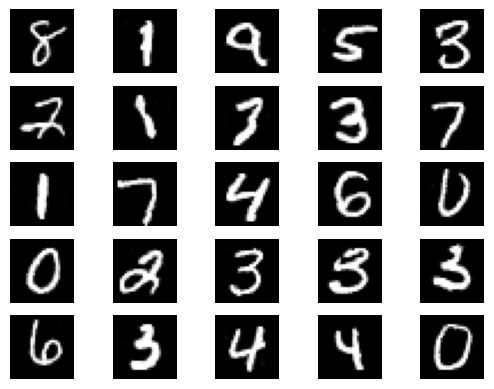

In [53]:
import matplotlib.pyplot as plt

batch_size = 25
latent_dim = 100
fixed_noise = torch.randn(batch_size, latent_dim, 1, 1, device=device)
fake_images = netG(fixed_noise).cpu().detach().numpy()
fake_images = fake_images.reshape(-1, 28, 28)
R, C = 5, 5
for i in range(batch_size):
    plt.subplot(R, C, i+1)
    plt.imshow(fake_images[i], cmap='gray')
    plt.axis('off')
plt.show()

### Generate GIF file

In [57]:
import imageio.v2
import glob

anim_file = 'dcgan.gif'
with imageio.v2.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('fake_samples*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.v2.imread(filename)
        writer.append_data(image)
